In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
import torch
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

length = 5000

Use CPU


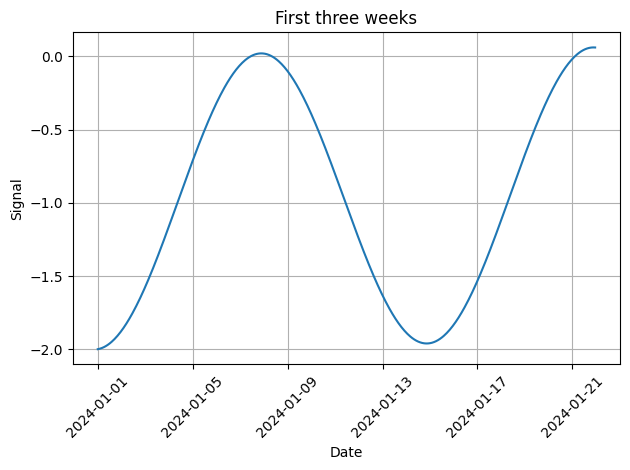

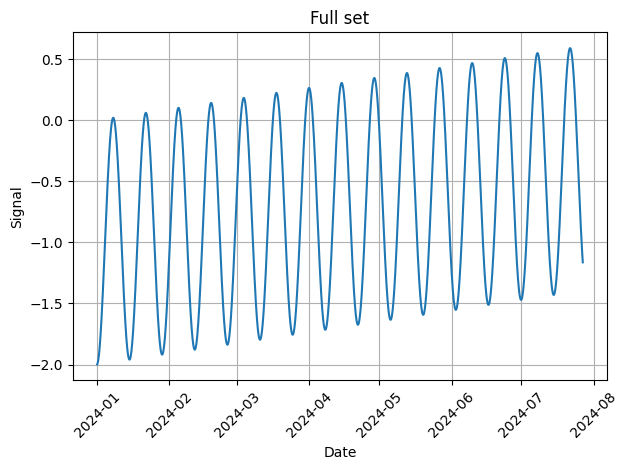

In [2]:
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0)
dp.add_sine([(1/336, 1)])
dp.add_trend(1, 1/336)
dp.plot_data()
dp.generate_csv()

In [3]:
def forward_hook(module, input, output):
    print("Module:", module.__class__.__name__)
    print("Input:", input[0].shape)
    print("Output:", output.shape)
    print(10*'-')

In [4]:
from model_components import PretrainHead
exp = SimpleExp(args)
exp.model.model.head = PretrainHead(
    d_model=args.d_model,
    patch_len=args.patch_len,
    dropout=0
)

Use CPU


In [5]:
exp.train()

train 2973
val 309
test 809
Validation loss decreased (inf --> 2.966859).  Saving model ...
Updating learning rate to 5.774693366163212e-05
EarlyStopping counter: 1 out of 10
Updating learning rate to 9.397136860148879e-09
Total training time: 0 minutes 5.554059028625488 seconds


<All keys matched successfully>

In [4]:
from PatchTST.PatchTST_supervised.models import PatchTST
from model_components import PretrainHead
args = Namespace(**config)
pretrain_model = PatchTST.Model(args)

pretrain_head = PretrainHead(
    d_model=args.d_model,
    patch_len=args.patch_len,
    dropout=0
)
pretrain_model.model.head = pretrain_head

In [5]:
pretrain_model

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.3, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.3, inplace=False)
  

In [5]:
hook_handles = []

hook_handles.append(pretrain_model.model.backbone.register_forward_hook(forward_hook))
hook_handles.append(pretrain_model.model.head.register_forward_hook(forward_hook))
hook_handles.append(pretrain_model.model.padding_patch_layer.register_forward_hook(forward_hook))

In [41]:
from PatchTST.PatchTST_supervised.data_provider.data_factory import data_provider

train_data, train_loader = data_provider(args,'train')
train_steps = len(train_loader)
device = torch.device('cpu')
optimiser = torch.optim.Adam(pretrain_model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer=optimiser,
                steps_per_epoch=train_steps,
                pct_start=args.lr_pct_start or 0.1,
                epochs=args.train_epochs,
                max_lr=args.lr
)
criterion = torch.nn.MSELoss()

train 2973


In [8]:
args.training_task = 'self_supervised'
args.mask_pct = 0.4

In [42]:
import random
pretrain_model.train()
for i, (batch_x, batch_y, _, _) in enumerate(train_loader):
    optimiser.zero_grad()
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    
    # if self supervised:
    #   make copy unmasked_batch_x
    #   draw random masked_indices of batch_x,
    #   set masked_indices of batch_x to zero
    #   predict using masked batch_x
    #   extract values at masked_indices from batch_x and output
    #   calculate loss as mse between output and unmasked_batch_x at indices
    
    if args.training_task == 'self_supervised':
        unmasked_batch_x = batch_x.clone()
        num_patches = int((args.seq_len - args.patch_len) / args.stride + 1)
        num_indices = int(args.mask_pct*num_patches)
        mask_indices_mtx = torch.zeros_like(batch_x, dtype=torch.bool)
        for b in range(args.batch_size):
            mask_start_indices = sorted(random.sample(range(num_patches), num_indices))
            mask_indices = []
            for index in mask_start_indices:
                start = index * args.stride
                end = start + args.patch_len
                mask_indices.extend(range(start, end))
            batch_x[b, mask_indices, 0] = 0  # todo: not ready for mv data
            mask_indices_mtx[b,mask_indices, 0] = True
    
    outputs = pretrain_model(batch_x)
    masked_outputs = outputs[mask_indices_mtx]
    trues = unmasked_batch_x[mask_indices_mtx]
    
    print(criterion(masked_outputs, trues))
    
    break


Module: ReplicationPad1d
Input: torch.Size([32, 1, 336])
Output: torch.Size([32, 1, 348])
----------
Module: TSTiEncoder
Input: torch.Size([32, 1, 12, 29])
Output: torch.Size([32, 1, 128, 29])
----------
Module: PretrainHead
Input: torch.Size([32, 1, 128, 29])
Output: torch.Size([32, 1, 336])
----------
tensor(0.8396, grad_fn=<MseLossBackward0>)


In [44]:
mask_indices_mtx.shape

torch.Size([32, 336, 1])

In [27]:
torch.masked_select()

torch.Size([4224])

In [16]:
print(outputs.shape)
masked_outputs = outputs[torch.tensor(mask_indices_mtx)]

torch.Size([32, 336, 1])


IndexError: tensors used as indices must be long, byte or bool tensors

In [12]:
masked_outputs.shape

torch.Size([32, 336, 1, 336, 1])

In [119]:
import pandas as pd 
inp = batch_x.detach().numpy()[0,:,0]
outp = outputs.detach().numpy()[0,:args.seq_len,0]
true = unmasked_batch_x.detach().numpy()[0,:,0]
mask = mask_indices_mtx[0,:,0]
df = pd.DataFrame({'input': inp,
                   'true': true,
                   'output': outp,
                   'mask': mask,
                   })
df

,input,true,output,mask
0,-1.081428,-1.081428,-1.322274,0.0
1,-1.080259,-1.080259,0.024544,0.0
2,-1.078832,-1.078832,-0.557847,0.0
3,-1.077147,-1.077147,-0.533161,0.0
4,-1.075206,-1.075206,-0.028275,0.0
...,...,...,...,...
331,-0.796416,-0.796416,-0.631262,0.0
332,-0.796518,-0.796518,-0.687909,0.0
333,-0.796362,-0.796362,-0.332096,0.0
334,-0.795948,-0.795948,-0.242405,0.0


,input,true,output,mask
0,-1.081428,-1.081428,-1.322274,0.0
1,-1.080259,-1.080259,0.024544,0.0
2,-1.078832,-1.078832,-0.557847,0.0
3,-1.077147,-1.077147,-0.533161,0.0
4,-1.075206,-1.075206,-0.028275,0.0
...,...,...,...,...
331,-0.796416,-0.796416,-0.631262,0.0
332,-0.796518,-0.796518,-0.687909,0.0
333,-0.796362,-0.796362,-0.332096,0.0
334,-0.795948,-0.795948,-0.242405,0.0


In [99]:
outp.shape

(32, 336)

In [9]:
outputs = outputs[:, :-args.stride, :]

outputs.shape

torch.Size([32, 336, 1])

torch.Size([32, 336, 1])

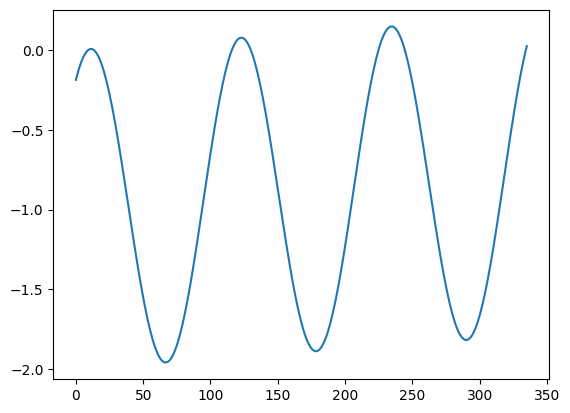

In [13]:
plt.plot(x[0,:,0])

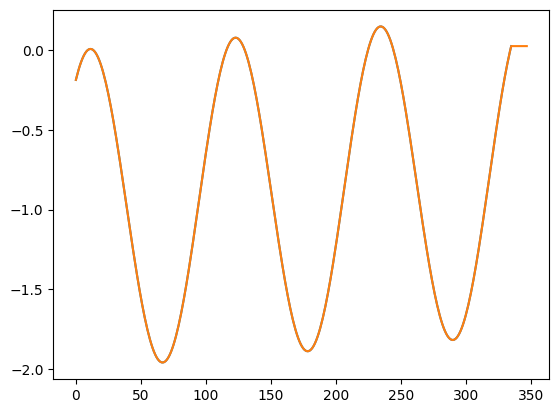

In [12]:
last_value = x[:, -1:, :]
repeated_last_value = last_value.repeat(1, 12, 1)

x2 = torch.cat((x, repeated_last_value), dim=1)
plt.plot(x2[0,:,0])

In [22]:
x3 = x2.view(1, 29, 1, 12)
x4 = x3.view(1, 1, -1)

torch.Size([1, 1, 348])

In [39]:
pretrain_model(x)

tensor([[[-0.8716],
         [-0.2753],
         [-0.7689],
         [-1.3942],
         [-0.9625],
         [-1.1463],
         [-1.1390],
         [-0.7930],
         [-0.8534],
         [ 0.0649],
         [-1.1980],
         [-1.8396],
         [-1.2629],
         [-0.5172],
         [-0.5467],
         [-1.3426],
         [-1.0523],
         [-0.6087],
         [-1.0508],
         [-1.0006],
         [-1.4132],
         [-0.4547],
         [-0.5883],
         [-1.5894],
         [-0.8160],
         [-0.6487],
         [-0.9927],
         [-1.0008],
         [-0.8850],
         [-0.6191],
         [-0.8119],
         [-0.6008],
         [-1.1093],
         [-0.9482],
         [-0.6908],
         [-1.4445],
         [-0.7422],
         [-1.1104],
         [-0.6808],
         [-0.9097],
         [-0.6835],
         [-0.5985],
         [-0.2257],
         [-0.8362],
         [-0.9777],
         [-1.2977],
         [-0.8462],
         [-0.7158],
         [-1.1817],
         [-1.7625],


train 2973


In [37]:
torch.nn.MSELoss(pretrain_model(x)[:,:-args.stride,:], x, )

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [36]:
pretrain_model(x)[:,:-args.stride,:].shape

torch.Size([1, 336, 1])

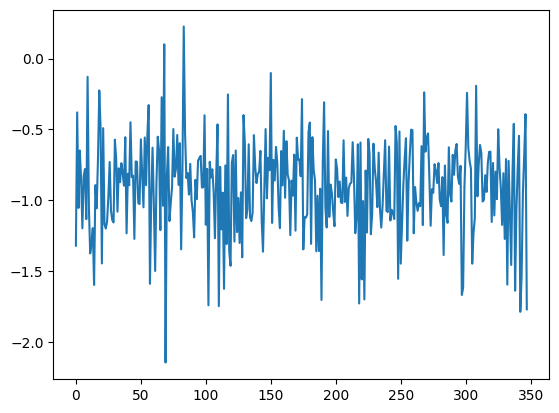

In [27]:
plt.plot(pretrain_model(x)[0,:,0].detach())

In [82]:
x = torch.rand([1, 336, 1])
x[0,0,0]

tensor(0.8629)

In [15]:
pretrain_model

True

In [29]:
a.flatten(start_dim=1, end_dim=3)

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [10]:
a = torch.arange(32*29*12).reshape(32, 1, 29, 12)
a = a.flatten(start_dim=2)
a[0,0,:]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [6]:
x = torch.rand([1, 336, 1])
pretrain_model(x)

before permute before revin denorm: torch.Size([1, 29, 1, 12])


RuntimeError: number of dims don't match in permute

## todo:
- make model be able data of same input (permute/view or something)
- hide some patches (after patching in backbone forward)
- validate in same manner
  - a first approach is to use the mse loss as usual, however this will be a bit blunt since we will get a lot of patches that are fed to the model
  - a better way would be to only calculate the loss of missing patches, however this requires some more work
